In [34]:
import copy
import os
import json
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from data_utils import merge_lists, gen_clean

with open(os.path.join('../data/data_lyrics.json'), 'r') as fp:
    lyrics_data = json.load(fp)
with open(os.path.join('../data/data_news.json'), 'r') as fp:
    news_data = json.load(fp)
with open(os.path.join('../data/data_rap.json'), 'r') as fp:
    raw_rap_data = json.load(fp)

gen_clean_control = {'lemmatize': True, 'stop_words': False, 'remove_number': True,}
all_data = gen_clean(merge_lists(lyrics_data) + merge_lists(news_data) + merge_lists(raw_rap_data), gen_clean_control)

In [52]:
from data_utils import add_some_music, gen_pre_data_preprocession, add_some_news, dis_pre_data_preprocession, get_dev_data

gen_percentage = 0.7 # percentage for generator pretraining from rap data
music_percentage = 0.1 # percentage of music added into rap lyrics

# generator data preprocessing
rap_music = add_some_music(raw_rap_data, lyrics_data, music_percentage)
final_train, gen_pre, dis_rap_raw = gen_pre_data_preprocession(rap_music, gen_percentage, gen_clean_control)

# discriminator data preprocessing
rap_news = add_some_news(dis_rap_raw, news_data)
dis_pre = dis_pre_data_preprocession(rap_news)

# get validation data
pre_dev_percentage = 0.1
gen_pre, gen_pre_dev = get_dev_data(gen_pre, pre_dev_percentage)
dis_pre, dis_pre_dev = get_dev_data(dis_pre, pre_dev_percentage)

In [53]:
from sentence_transformers import SentenceTransformer
sen_embed = SentenceTransformer('bert-base-nli-mean-tokens')

In [54]:
from dataset import GENDataset, DISDataset, basic_collate_fn
import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--pre-train-epochs', type=int, default=30)
# parser.add_argument('--batch-size', type=int, default=256)
# parser.add_argument('--sequence-length', type=int, default=5)
# gen_args = parser.parse_args()

gen_args = {"pre_train_epochs": 10, "batch_size": 256, "sequence_length": 5}

# new_parser = argparse.ArgumentParser()
# new_parser.add_argument('--pre-train-epochs', type=int, default=30)
# dis_args = new_parser.parse_args()

dis_args = {"pre_train_epochs": 10}

dis_batch_size = 32

# gen_pre = gen_pre[0:512]
# gen_pre_dev = gen_pre
# dis_pre_dev = dis_pre[0:256] + dis_pre[-256:]
# final_train = gen_pre
# dis_pre = dis_pre[0:256] + dis_pre[-256:]

gen_pre_data = GENDataset(gen_args, gen_pre, all_data)
gen_pre_dev_data = GENDataset(gen_args, gen_pre_dev, all_data)
final_train_data = GENDataset(gen_args, final_train, all_data)

dis_pre_data = DISDataset(dis_pre, sen_embed)
dis_pre_dev_data = DISDataset(dis_pre_dev, sen_embed)

gen_dataloader = DataLoader(gen_pre_data, batch_size=gen_args["batch_size"])
gen_dev_loader = DataLoader(gen_pre_dev_data, batch_size=1)
final_loader = DataLoader(final_train_data, batch_size=1)

dis_dataloader = DataLoader(dis_pre_data, batch_size=dis_batch_size, collate_fn=basic_collate_fn, shuffle=True)
dis_dev_loader = DataLoader(dis_pre_dev_data, batch_size=gen_args["batch_size"])

In [55]:
from model.generator import Generator
from model.discriminator import Discriminator

lstm_input_size, num_layers, lstm_hidden_dim, dropout = 128, 2, 32, 0.1
dis_hidden_dim = 1024

generator = Generator(gen_pre_data, lstm_input_size, num_layers, lstm_hidden_dim, dropout)
discriminator = Discriminator(dis_hidden_dim)

In [56]:
from train import pre_train_generator, pre_train_discriminator

device = 'cpu'
pre_patience = 10

gen_loss_type, gen_optim_type = 'cross', 'adam'
g_lr, g_weight_decay = 0.001, 0.00001

dis_loss_type, dis_optim_type = 'bce', 'adam'
d_lr, d_weight_decay = 0.001, 0.00001

generator = pre_train_generator(gen_args, generator, gen_dataloader, gen_dev_loader, gen_loss_type, gen_optim_type, g_lr, g_weight_decay, pre_patience, device)
discriminator = pre_train_discriminator(dis_args, discriminator, dis_dataloader, dis_dev_loader, dis_loss_type, dis_optim_type, d_lr, d_weight_decay, pre_patience, device)

{'epoch': 0, 'batch': 0, 'loss': 11.140585899353027}
{'epoch': 0, 'batch': 1, 'loss': 11.141411781311035}
{'epoch': 0, 'batch': 2, 'loss': 11.120870590209961}
{'epoch': 0, 'batch': 3, 'loss': 11.117223739624023}
{'epoch': 0, 'batch': 4, 'loss': 11.114075660705566}
{'epoch': 0, 'batch': 5, 'loss': 11.111823081970215}
{'epoch': 0, 'batch': 6, 'loss': 11.097861289978027}
{'epoch': 0, 'batch': 7, 'loss': 11.083054542541504}
{'epoch': 0, 'batch': 8, 'loss': 11.067007064819336}
{'epoch': 0, 'batch': 9, 'loss': 11.045952796936035}
{'epoch': 0, 'batch': 10, 'loss': 11.009347915649414}
{'epoch': 0, 'batch': 11, 'loss': 10.983124732971191}
{'epoch': 0, 'batch': 12, 'loss': 10.956881523132324}
{'epoch': 0, 'batch': 13, 'loss': 10.854954719543457}
{'epoch': 0, 'batch': 14, 'loss': 10.718844413757324}
{'epoch': 0, 'batch': 15, 'loss': 10.586824417114258}
{'epoch': 0, 'batch': 16, 'loss': 10.450711250305176}
{'epoch': 0, 'batch': 17, 'loss': 10.180136680603027}
{'epoch': 0, 'batch': 18, 'loss': 9.98

In [14]:
def get_hyper_parameters():
    _g_para_list = [{"optim_type": 'adam', 'lr': 0.01, "weight_decay": 1e-4}]
    _d_para_list = [{"optim_type": 'adam', 'lr': 0.01, "weight_decay": 1e-4}]
    _num_epoch = 40
    _patience = 10
    _max_words = 10
    _device = 'cpu'
    return _g_para_list, _d_para_list, _num_epoch, _patience, _max_words, _device

------------------------ Start Training ------------------------
Epoch No. 1 -- generator loss = -1.2298 -- discriminator loss = 0.2565
Validation Generator loss: -847.9710
Validation Discriminator loss: -144.0315
Training lasted 1.83 minutes
------------------------ Training Done ------------------------


Best hidden dimension: 0, Best learning rate: 0, best weight_decay: 0, best batch_size: 0, best loss type： , best optimizer: 
Generator loss: -1.6344
Discriminator loss: -0.2781


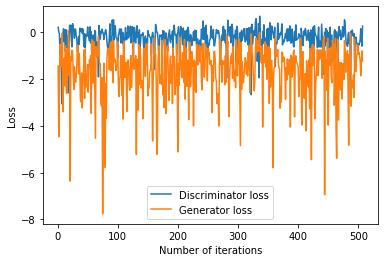

In [15]:
import itertools
from train import train_model
from data_utils import plot_loss
from generate_rap import generate_rap
import numpy as np

g_para_list, d_para_list, num_epoch, patience, max_words, device = get_hyper_parameters()

# model training
best_gen, best_dis, best_stats = copy.deepcopy(generator), copy.deepcopy(discriminator), None
best_lr, best_wd, best_bs, best_hd, best_lt, best_om = 0, 0, 0, 0, '', ''
best_dis_loss, best_gen_loss = float('-inf'), float('inf')
for g_para, d_para in itertools.product(g_para_list, d_para_list):
    g, d, stats = train_model(generator, discriminator, final_loader, final_train_data, num_epoch, g_para, d_para, gen_dev_loader, patience, max_words, device)

    # update best parameters if needed
    if np.mean(stats['dis_loss']) > best_dis_loss and np.mean(stats['gen_loss']) < best_gen_loss:
        best_dis_loss = np.mean(stats['dis_loss'])
        best_gen_loss = np.mean(stats['gen_loss'])
        best_gen, best_dis, best_stats = copy.deepcopy(g), copy.deepcopy(d) , copy.deepcopy(stats)
        best_g_para, best_d_para = g_para, d_para

    print("\n\nBest hidden dimension: {}, Best learning rate: {}, best weight_decay: {}, best batch_size: {}, best loss type： {}, best optimizer: {}".format(
    best_hd, best_lr, best_wd, best_bs, best_lt, best_om))
print("Generator loss: {:.4f}".format(best_gen_loss))
print("Discriminator loss: {:.4f}".format(best_dis_loss))
plot_loss(best_stats)

In [33]:
from generate_rap import generate_rap

sen_input = "i build a castle"
num_sentences = 10
max_words = 10

lyrics = generate_rap(best_gen, sen_input, num_sentences, max_words, final_train_data)
for sen in lyrics:
    print(sen)

diggity crunchin yuliya shaunking sallie agitator
vitart bagenstos flatiron distributor ngauea laurens insideclimate
police
reproduction
shawshank undeveloped sharpeis lovemark penjing multistate
oeuvre moshpit bhangra historical
contested eezy layover rattanawitthayapol smeared excercise imperceptibly
neller mohammedan calvary diseffect proactiva

lunsford funky ingenuity retrenched
